# Challenge Data Scientist - Javiera Morales

El problema que se busca solucionar en este desafío es predecir la **probabilidad** de atraso de los vuelos que aterrizan
o despegan del aeropuerto de Santiago de Chile.

Iniciamos el desafío importando los paquetes de python necesarios para la resolución de este.

In [1]:
# Para trabajo con el dataset
import pandas as pd
import numpy as np
from datetime import datetime
import statsmodels.api as sm

# Para visualización de los datos
import seaborn as sns
import matplotlib.pyplot as plt

# Para realizar modelos de machine learning para resolver el problema
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# Para obtener métricas
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, \
    roc_curve, precision_recall_curve, f1_score, auc

import warnings
warnings.filterwarnings('ignore')

sns.set_style("darkgrid")

Primero debemos cargar el dataset entregado que cuenta con información de vuelos que despegaron y aterrizaron en el
aeropuerto de Santiago.

In [2]:
dataset_scl = pd.read_csv('dataset_SCL.csv')

# Visualicemos las primeras 5 líneas del dataset (5 vuelos)
dataset_scl.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


### 1. Distrbución de los datos - EDA
La primera pregunta que buscamos resolver es cómo se distribuyen los datos entregados, para lo que realizaremos
visualización gráfica de datos y posterior análisis cuantitativo para responder.

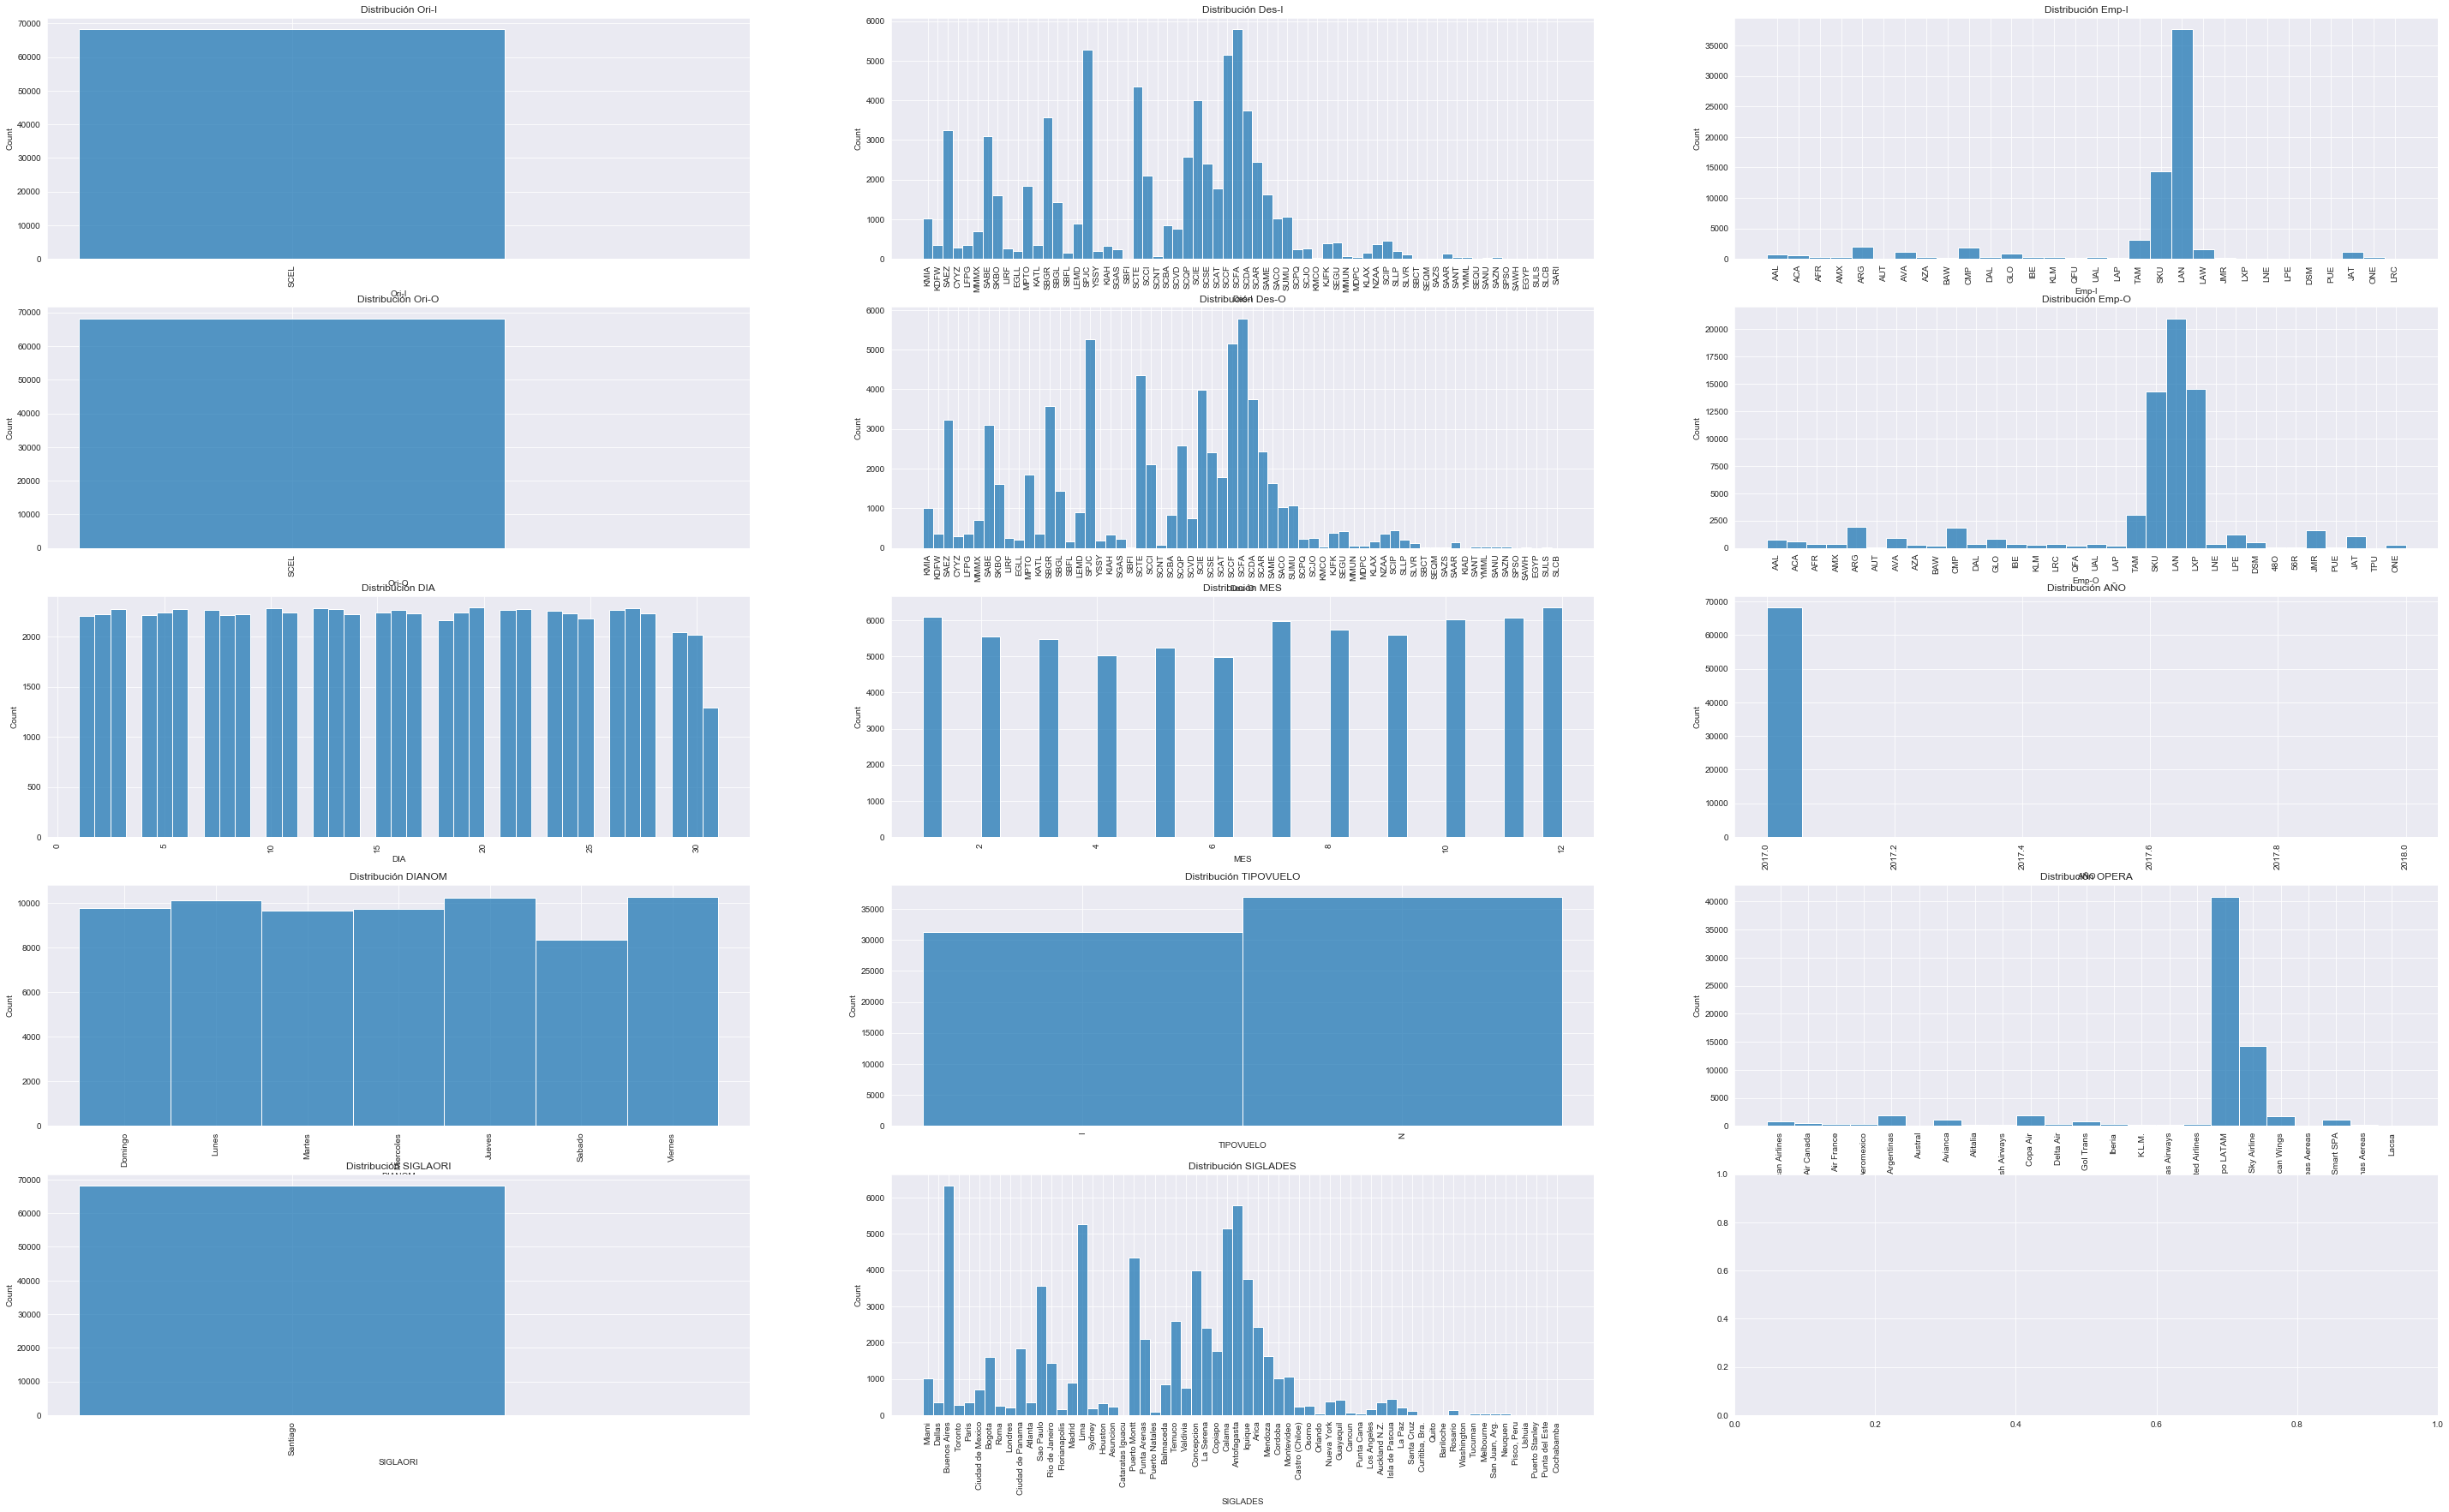

In [3]:
variable_list = ['Ori-I', 'Des-I','Emp-I','Ori-O','Des-O','Emp-O',
                 'DIA','MES','AÑO','DIANOM','TIPOVUELO','OPERA','SIGLAORI','SIGLADES']
fig, axes = plt.subplots(5, 3, figsize = (50,30))
for var, ax in zip(variable_list, axes.flat):
    sns.histplot(dataset_scl[var], ax=ax)
    ax.set_title('Distribución {}'.format(var))
    ax.tick_params(axis='x', rotation=90)
plt.show()

In [4]:
#Distribución de vuelos (cantidad de vuelos por distintas variables) en números
print('Total de vuelos:', dataset_scl['Vlo-I'].count())
print('Total de destinos:', dataset_scl['SIGLADES'].nunique())
print('Distribución agruapada:')
for var in ['DIA','MES','DIANOM','TIPOVUELO','OPERA','SIGLADES']:
    temp_df = dataset_scl[['Vlo-I',var]].groupby(var).count().sort_values('Vlo-I',ascending=False)
temp_df

Total de vuelos: 68206
Total de destinos: 62
Distribución agruapada:


,Vlo-I
SIGLADES,
Buenos Aires,6335
Antofagasta,5786
Lima,5270
Calama,5146
Puerto Montt,4357
...,...
Cataratas Iguacu,2
"Pisco, Peru",1
Puerto Stanley,1


De las distribuciones vistas de los datos podemos concluir que la ciudad de origen en todos los datos es Santiago de
Chile, tanto en lo programado como lo de operación. Además todos los datos que se tienen en la base de datos
corresponden a vuelos del año 2017.

Respecto a los meses, días y días de la semana de operación de los vuelos, no se ve gran diferencia entre los valores
de cada uno respectivamente, para los meses, se ve mayor cantidad de vuelos en los meses de Enero, Julio, Noviembre y
Diciembre, que corresponden a meses de temporada alta comúnmente en las vacaciones de verano e invierno de Chile,
los vuelos mensuales rondan entre los 5000 y 6000 vuelos; revisando la distribución por día del mes, siendo estos
alrededor de 2000 vuelos por día, se puede ver claramente una menor cantidad de vuelos en el último día 31 del mes,
pero también puede corresponder a que la mitad de los meses cuentan con el día 31, pero si se aprecia una baja de 200
vuelos aproximadamente en los últimos 3 días del mes; revisando los días de la semana, los días lunes, jueves y viernes
son los días con mayor cantidad de salidas de vuelos, superando los 10000 vuelos por día, mientras que los sábados son
los que menores salidas tienen, siendo estas una cantidad bajo 9000 vuelos.

Revisemos ahora la distribución de los datos por tipos de vuelo, salen más vuelos nacionales desde el aeropuerto de
Santiago que internacionales, pero no por una diferencia muy grande, esta diferencia es de 5726 vuelos. Las aerolíneas
con mayor operación corresponden a la del Grupo LATAM, seguido por Sky Airline, concentrando el 80% de los vuelos que
salen desde el aeropuerto de Santiago de Chile, Grupo LATAM solo se lleva cercano del 60% de los vuelos. Finalmente,
del total de 62 destinos que se encuentran en el dataset, los 5 destinos que más vuelos tuvieron durante el año 2017
son Buenos Aires, Antofagasta, Lima, Calama y Puerto Montt con más de 5000 vuelos al año y los destinos con menos
vuelos, Pisco, Puerto Stanley, Cochabamba y Washington con un solo vuelo en el año.

### 2. Creación de variables sintéticas para el análisis y modelo

Generemos ahora las variables adicionales que nos ayudarán a generar un modelo predictivo de atraso de vuelo.

In [5]:
# Primero cambiemos las variables de Fecha-I y Fecha-O a variables tipo datetime, dado que son variables tipo str.
dataset_scl['Fecha-I'] = pd.to_datetime(dataset_scl['Fecha-I'])
dataset_scl['Fecha-O'] = pd.to_datetime(dataset_scl['Fecha-O'])

# Variable temporada alta
temporada_conditions = [
    ((dataset_scl['Fecha-I'].dt.date >= datetime.strptime('2017-07-15', '%Y-%m-%d').date())
     & (dataset_scl['Fecha-I'].dt.date <= datetime.strptime('2017-07-31', '%Y-%m-%d').date()))
|   ((dataset_scl['Fecha-I'].dt.date >= datetime.strptime('2017-09-11', '%Y-%m-%d').date())
     & (dataset_scl['Fecha-I'].dt.date <= datetime.strptime('2017-09-30', '%Y-%m-%d').date()))
|   ((dataset_scl['Fecha-I'].dt.date >= datetime.strptime('2017-01-01', '%Y-%m-%d').date())
     & (dataset_scl['Fecha-I'].dt.date <= datetime.strptime('2017-03-03', '%Y-%m-%d').date()))
|   ((dataset_scl['Fecha-I'].dt.date >= datetime.strptime('2017-12-15', '%Y-%m-%d').date()))

]
temporada_choices = [1]
dataset_scl['temporada_alta'] = np.select(temporada_conditions, temporada_choices, default=0)

# Diferencia en minutos
dataset_scl['dif_min'] = (dataset_scl['Fecha-O']- dataset_scl['Fecha-I']).dt.total_seconds()/60

# Booleano de si está atrasado o no el vuelo por 15 minutos
dataset_scl['atraso_15'] = np.where(dataset_scl['dif_min'] > 15, 1, 0)

# Periodo del día en que ocurre el vuelo (mañana, tarde, noche) en base a Fecha-I
period_conditions = [(dataset_scl['Fecha-I'].dt.time >= datetime.strptime('05:00:00', '%H:%M:%S').time())
                     & (dataset_scl['Fecha-I'].dt.time <= datetime.strptime('11:59:00', '%H:%M:%S').time()),
                     (dataset_scl['Fecha-I'].dt.time >= datetime.strptime('12:00:00', '%H:%M:%S').time())
                     & (dataset_scl['Fecha-I'].dt.time <= datetime.strptime('18:59:00', '%H:%M:%S').time())
                     ]
period_choices = ['mañana','tarde']
dataset_scl['periodo_dia'] = np.select(period_conditions, period_choices, default='noche')

Estas variables las guardaremos ahora en un archivo de csv separado con separador ";"

In [6]:
dataset_scl[['temporada_alta','dif_min','atraso_15','periodo_dia']].to_csv('synthetic_features.csv',sep = ';')

### 3. Entendimiento tasa de atraso
Debemos revisar ahora el comportamiento de la tasa de atraso dependiendo de distintas variables, por destino,
aerolínea, mes del año, día de la semana, temporada y tipo de vuelo. Para revisar gráficamente el comportamiento de los
atrasos por las variables mencionadas se realizan boxplots, los que permiten identificar puntos atípicos (outliers) y
además identificar cómo se concentran los datos en los diferentes cuartiles, donde la barra del medio de la caja
corresponde a la media.

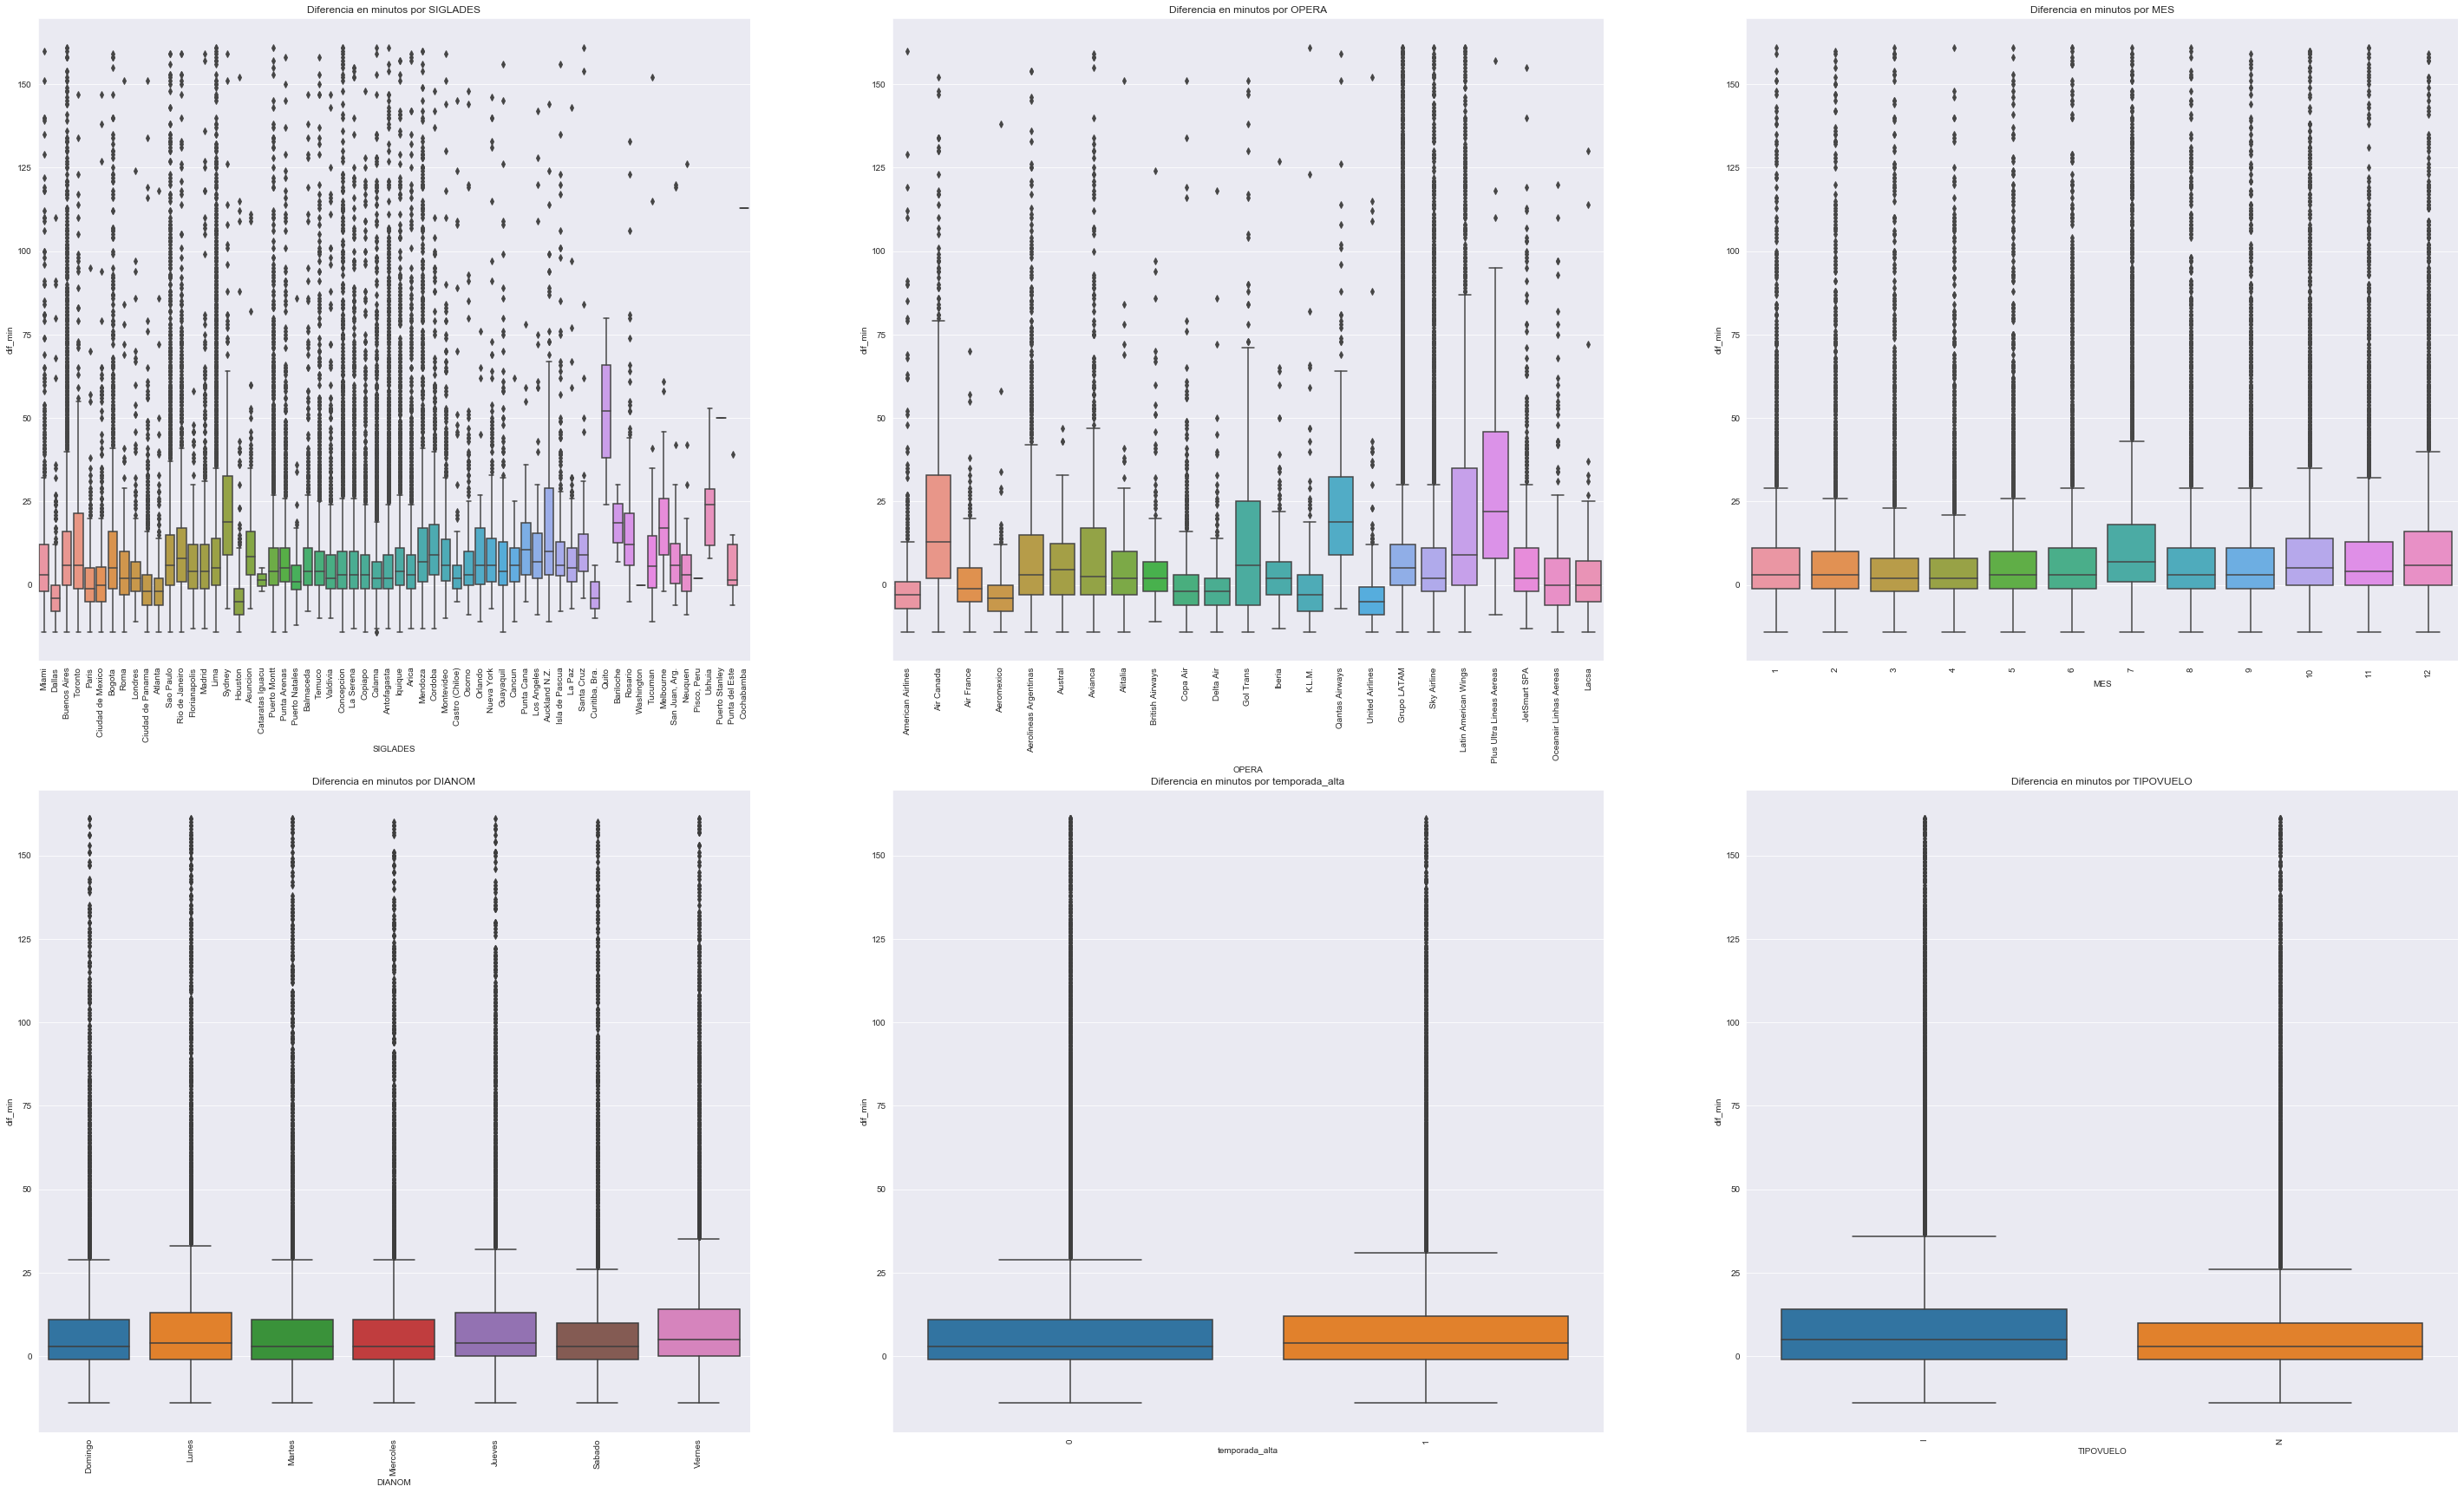

In [7]:
var_influence_list = ['SIGLADES','OPERA','MES','DIANOM','temporada_alta','TIPOVUELO']
fig, axes = plt.subplots(2, 3, figsize = (50,30))
for var, ax in zip(var_influence_list, axes.flat):
    sns.boxplot(x=var,y='dif_min',data=dataset_scl, ax = ax)
    ax.set_title('Diferencia en minutos por {}'.format(var))
    ax.tick_params(axis='x', rotation=90)
plt.show()

In [8]:
dataset_scl['atraso_15'].value_counts()
print('Tasa de atraso general:',round(len(dataset_scl[dataset_scl['atraso_15']==1])/len(dataset_scl),3))

Tasa de atraso general: 0.185


Ahora crearemos la variable tasa de atraso en un dataset acotado a las variables que se buscan que puedan explicar el
atraso en los vuelos.

In [9]:
sum_dataset = dataset_scl[['OPERA','SIGLADES','DIANOM','TIPOVUELO','temporada_alta','MES','atraso_15']].groupby(
    ['OPERA','SIGLADES','DIANOM','TIPOVUELO','temporada_alta','MES']).sum()
count_dataset = dataset_scl[['OPERA','SIGLADES','DIANOM','TIPOVUELO','temporada_alta','MES','atraso_15']].groupby(
    ['OPERA','SIGLADES','DIANOM','TIPOVUELO','temporada_alta','MES']).count()

late_rate = pd.merge(sum_dataset,count_dataset, left_index=True, right_index=True)
late_rate['tasa_atraso'] = late_rate.atraso_15_x/late_rate.atraso_15_y
late_rate.reset_index(drop=False,inplace=True)
late_rate.head()

,OPERA,SIGLADES,DIANOM,TIPOVUELO,temporada_alta,MES,atraso_15_x,atraso_15_y,tasa_atraso
0,Aerolineas Argentinas,Buenos Aires,Domingo,I,0,3,1,19,0.052632
1,Aerolineas Argentinas,Buenos Aires,Domingo,I,0,4,3,29,0.103448
2,Aerolineas Argentinas,Buenos Aires,Domingo,I,0,5,5,24,0.208333
3,Aerolineas Argentinas,Buenos Aires,Domingo,I,0,6,5,24,0.208333
4,Aerolineas Argentinas,Buenos Aires,Domingo,I,0,7,2,12,0.166667


Para explicar qué variables afectan más a la tasa de atraso utilizaremos una regresión lineal explicativa.

In [10]:
# Creamos variables dummies para las categóricas para que puedan ser consideradas en la regresión
late_rate = pd.concat((late_rate,
                       pd.get_dummies(late_rate['OPERA'],drop_first=True),
                       pd.get_dummies(late_rate['SIGLADES'],drop_first=True),
                       pd.get_dummies(late_rate['DIANOM'],drop_first=True),
                       pd.get_dummies(late_rate['TIPOVUELO'],drop_first=True)), axis=1)
late_rate.head()

,OPERA,SIGLADES,DIANOM,TIPOVUELO,temporada_alta,MES,atraso_15_x,atraso_15_y,tasa_atraso,Aeromexico,...,Ushuia,Valdivia,Washington,Jueves,Lunes,Martes,Miercoles,Sabado,Viernes,N
0,Aerolineas Argentinas,Buenos Aires,Domingo,I,0,3,1,19,0.052632,0,...,0,0,0,0,0,0,0,0,0,0
1,Aerolineas Argentinas,Buenos Aires,Domingo,I,0,4,3,29,0.103448,0,...,0,0,0,0,0,0,0,0,0,0
2,Aerolineas Argentinas,Buenos Aires,Domingo,I,0,5,5,24,0.208333,0,...,0,0,0,0,0,0,0,0,0,0
3,Aerolineas Argentinas,Buenos Aires,Domingo,I,0,6,5,24,0.208333,0,...,0,0,0,0,0,0,0,0,0,0
4,Aerolineas Argentinas,Buenos Aires,Domingo,I,0,7,2,12,0.166667,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
y = late_rate['tasa_atraso']
X = late_rate.drop(['tasa_atraso','OPERA','SIGLADES','DIANOM','TIPOVUELO','atraso_15_x','atraso_15_y'],axis=1)
lm = sm.OLS(y, X)
res = lm.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            tasa_atraso   R-squared:                       0.245
Model:                            OLS   Adj. R-squared:                  0.237
Method:                 Least Squares   F-statistic:                     29.05
Date:                Wed, 09 Nov 2022   Prob (F-statistic):               0.00
Time:                        15:34:46   Log-Likelihood:                 1048.6
No. Observations:                7780   AIC:                            -1923.
Df Residuals:                    7693   BIC:                            -1318.
Df Model:                          86                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
temporada_alta          

Visualicemos gráficamente la tasa de atraso.

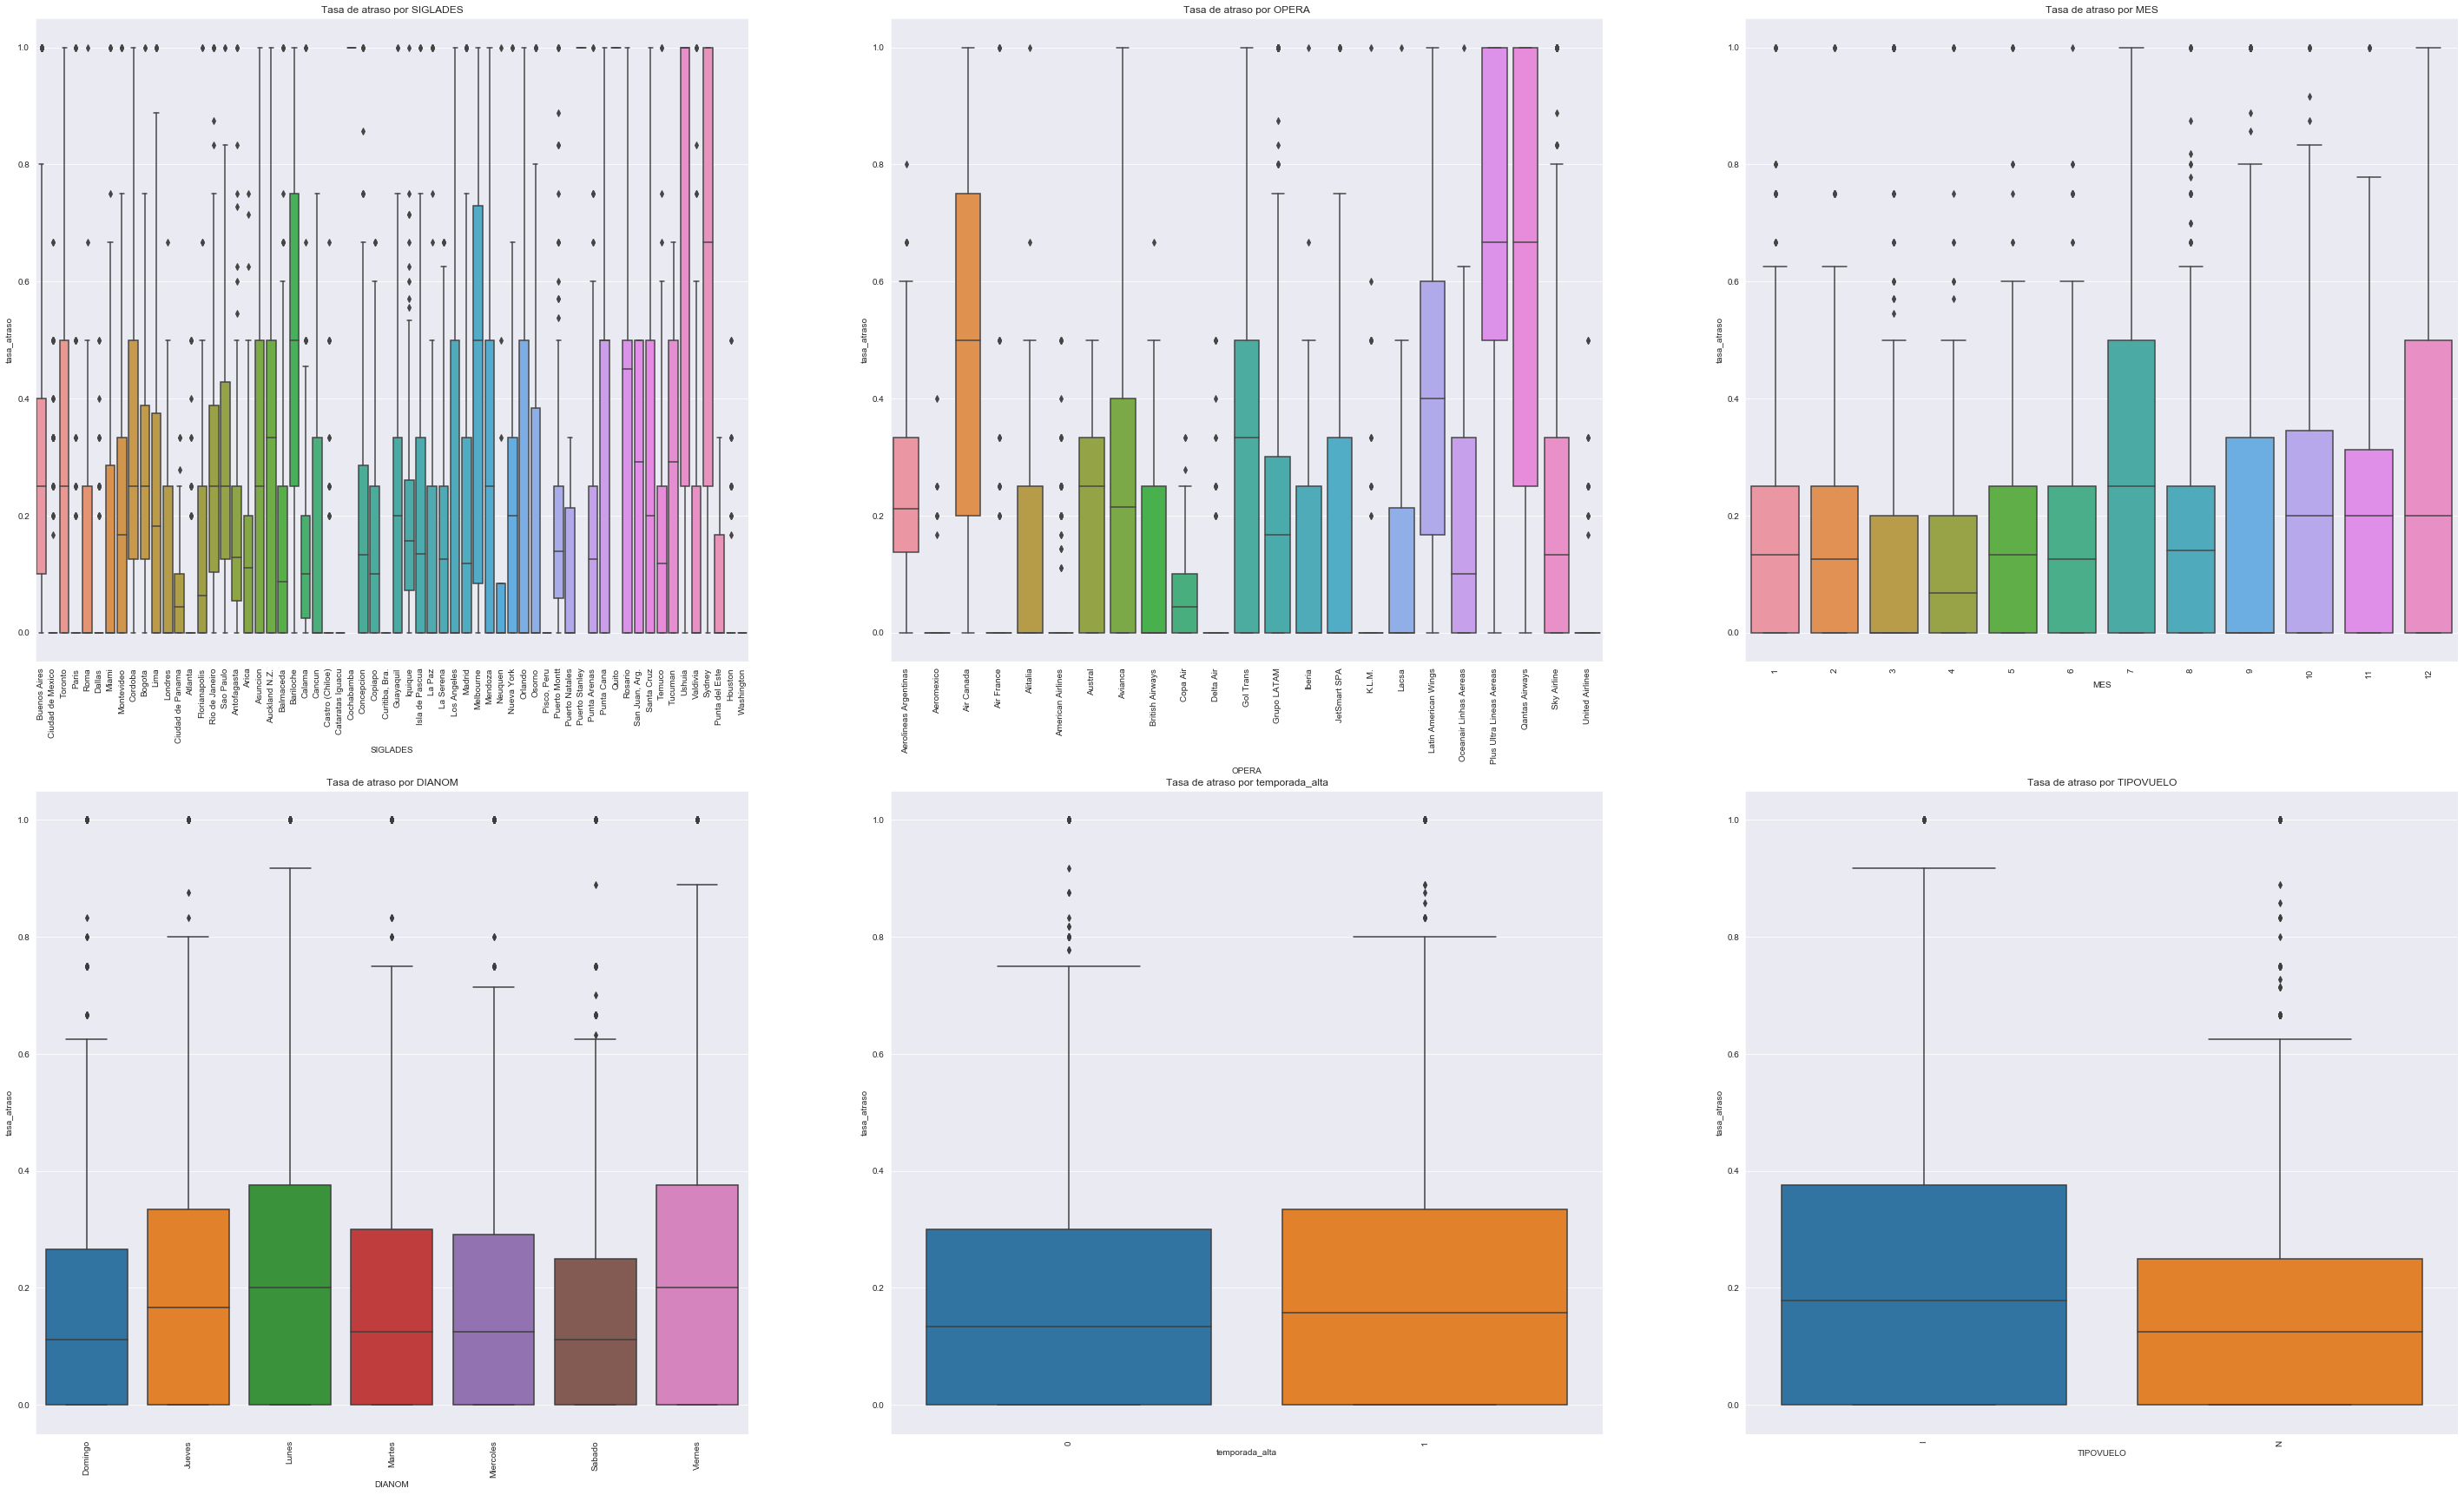

In [12]:
fig, axes = plt.subplots(2, 3, figsize = (50,30))
for var, ax in zip(var_influence_list, axes.flat):
    sns.boxplot(x=var,y='tasa_atraso',data=late_rate, ax = ax)
    ax.set_title('Tasa de atraso por {}'.format(var))
    ax.tick_params(axis='x', rotation=90)
plt.show()

Del comportamiento estudiado anteriormente podemos concluir que viendo el p-value (si el p-value es menor a 0.05 se
considera estadísticamente significativa la variable), las variables que más influirían en la predicción de atrasos
serían la **temporada**, el **mes de operación del vuelo**, el **día de la semana**, si es lunes, jueves o viernes,
algunas aerolíneas, pero las que tienen mayor cantidad de datos como LATAM y Sky no son significativas para predicir los
atrasos, algunos destinos también. Y lo que es relevante y sobresale a la vista es que el tipo de vuelo no sería
relevante en la predicción de atraso de vuelo, es decir, los atrasos son independientes de si el vuelo es nacional
o internacional. Si nos adelantamos, por ejemplo los lunes, se podría identificar el problema que genera los atrasos y
diseñar procesos que permitan agilizar los flujos de despegue y aterrizaje de aviones en el aeropuerto, dependiendo del
problema encontrado, lo mismo puede ser aplicado con las temporadas y los meses, anticiparse a que ocurrirán atrasos y
generar acciones para disminuir la tasa de atrasos.

### 4. Creación modelos predictivos

Continuamos ahora el desafío con la parte de entrenamiento del modelo. Para entrenar este modelo debemos considerar las
variables creadas anteriormente junto con las entregadas en el dataset original.

Este modelo corresponde a un modelo de clasificación, dado que consideraremos como atraso si la diferencia en minutos
entre Fecha-I y Fecha-O es de 15 minutos, tal como se creó la variable atraso_15. Por lo que utilizaremos dicha variable
como target para nuestro entrenamiento y posterior validación.

In [13]:
model_data = pd.concat((dataset_scl,
                        pd.get_dummies(dataset_scl['OPERA'],drop_first=True),
                        pd.get_dummies(dataset_scl['SIGLADES'],drop_first=True),
                        pd.get_dummies(dataset_scl['DIANOM'],drop_first=True),
                        pd.get_dummies(dataset_scl['periodo_dia'],drop_first=True)), axis=1)

In [14]:
X = model_data.loc[:, model_data.columns != 'atraso_15']
y = model_data.loc[:, model_data.columns == 'atraso_15']

# Eliminamos las variables que no utilizaremos en el modelo que ya son explicadas por otras variables
X.drop(['Fecha-I', 'Vlo-I', 'Ori-I', 'Des-I', 'Emp-I', 'Fecha-O', 'Vlo-O',
       'Ori-O', 'Des-O', 'Emp-O','SIGLAORI','dif_min','AÑO','TIPOVUELO',
        'OPERA','SIGLADES','DIANOM','periodo_dia'],axis = 1, inplace = True)

In [15]:
# Separamos en data de entrenamiento y de testeo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [16]:
pb_model = sm.Probit(y_train, X_train)
res_pb = pb_model.fit(method='bfgs')
print(res_pb.summary2())

         Current function value: 0.462790
         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39
                         Results: Probit
Model:              Probit           Pseudo R-squared: 0.033      
Dependent Variable: atraso_15        AIC:              50677.3544 
Date:               2022-11-09 15:34 BIC:              51452.2747 
No. Observations:   54564            Log-Likelihood:   -25252.    
Df Model:           86               LL-Null:          -26125.    
Df Residuals:       54477            LLR p-value:      1.0354e-307
Converged:          0.0000           Scale:            1.0000     
------------------------------------------------------------------
                           Coef.  Std.Err.  z  P>|z| [0.025 0.975]
------------------------------------------------------------------
DIA                       -0.0084      nan nan   nan    nan    nan
MES                        0.0182      nan nan   nan    nan    nan
temporada_alta       

El modelo no convergió, por lo que probaremos con otros tipos de modelos que no sean regresiones.

Probaremos modelos de árboles de clasificación. Primero un Random Forest y seguiremos con un XGBoost.

Además contamos con un dataset desbalanceado, como se muestra en el punto 3 de este reporte donde la tasa de atraso
general es de un 18%, es decir, 18% de nuestros datos están etiquetados como atrasados. Debido a este desbalance, se
analizará además un modelo de Ensamble con balanceo.

#### 4.1. Random Forest

El primer paso en un random forest es determinar el número de estimadores que se piensan utilizar, para esto se
utilizará un código iterativo que permita determinar gráficamente en qué punto se máximiza la métrica de accuracy (menor)
error en la predicción.

Text(0, 0.5, 'Testing Accuracy')

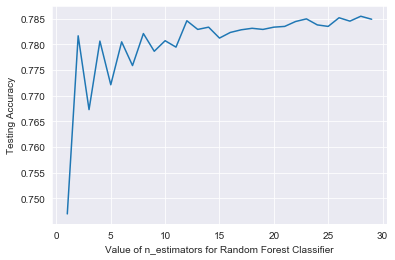

In [17]:
scores =[]
for n in range(1, 30):
    rf_class = RandomForestClassifier(n_estimators=n,
                                 max_features='auto',
                                 random_state=0)
    rf_class.fit(X_train, y_train)
    y_pred = rf_class.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))

plt.plot(range(1, 30), scores)
plt.xlabel('Value of n_estimators for Random Forest Classifier')
plt.ylabel('Testing Accuracy')

In [18]:
# Utilizamos la librería de Random Forest de scikit-learn Random Forest Classifier
# En base al gráfico de accuracy anterior el número de estimadores elegido es de 12.
rf_model = RandomForestClassifier(n_estimators=12,
                                  max_features='auto',
                                  random_state=0)
rf_model.fit(X_train,y_train)

rf_pred = rf_model.predict(X_test)
rf_probability = rf_model.predict_proba(X_test)

#### 4.2. XGBoost

In [19]:
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_probability = xgb_model.predict_proba(X_test)

#### 4.3. Ensemble Balance

In [20]:
bbc_model = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=0)
bbc_model.fit(X_train, y_train)
bbc_pred = bbc_model.predict(X_test)
bbc_probability = bbc_model.predict_proba(X_test)

Revisemos las métricas de los modelos y comparemos. Revisaremos la matriz de confusión, accuracy, recall, f1-score,
precision y además de la importancia de las variables con las que se entrena el modelo.

#### 4.4. Métricas
##### 4.4.1 Importancia de las variables

In [21]:
#Creamos la función que nos servirá para evaluar todos los modelos
def feature_importance(model):
    ax= plt.subplot()
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    feat_importances.nlargest(10).plot(kind='barh')
    ax.set_title('Top 10 variables importantes - {}'.format(type(model).__name__))
    ax.set_ylabel('Variable')
    ax.set_xlabel('Importancia')
    plt.show()

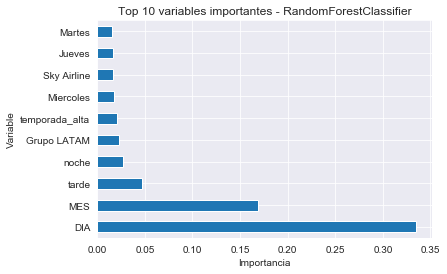

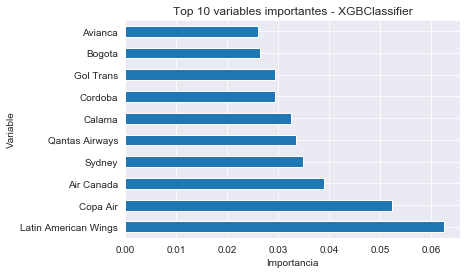

In [22]:
feature_importance(rf_model) # Random Forest
feature_importance(xgb_model) # XGBoost

##### 4.4.2 Matriz de confusión

In [23]:
#Creamos la función que nos servirá para evaluar todos los modelos
def conf_matrix(real, pred, model):
    cm = confusion_matrix(real, pred)

    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', cmap="crest",ax=ax) #annot=True to annotate cells, ftm='g' to disable scientific notation

    ax.xaxis.tick_top()
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix - {}'.format(type(model).__name__))
    ax.xaxis.set_ticklabels(['On Time', 'Late']); ax.yaxis.set_ticklabels(['On Time', 'Late'])
    plt.show()

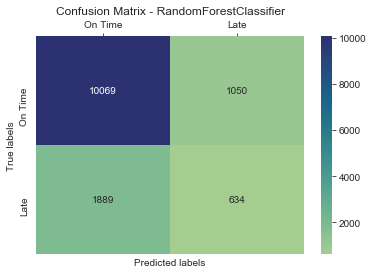

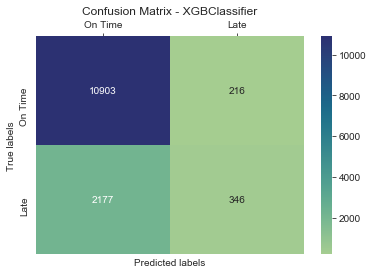

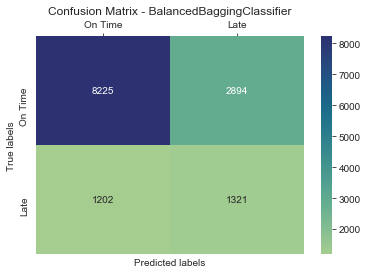

In [24]:
conf_matrix(y_test, rf_pred, rf_model) # Random Forest
conf_matrix(y_test, xgb_pred, xgb_model) # XGBoost
conf_matrix(y_test, bbc_pred, bbc_model) # Ensemble Balance

##### 4.4.3. Precision, Recall, F1-score, Accuracy, ROC-AUC Curve

In [25]:
print('Random Forest Report:', classification_report(y_test, rf_pred))
print('XGBoost Report:', classification_report(y_test, xgb_pred))
print('Ensemble Balance Report:', classification_report(y_test, bbc_pred))

Random Forest Report:               precision    recall  f1-score   support

           0       0.84      0.91      0.87     11119
           1       0.38      0.25      0.30      2523

    accuracy                           0.78     13642
   macro avg       0.61      0.58      0.59     13642
weighted avg       0.76      0.78      0.77     13642

XGBoost Report:               precision    recall  f1-score   support

           0       0.83      0.98      0.90     11119
           1       0.62      0.14      0.22      2523

    accuracy                           0.82     13642
   macro avg       0.72      0.56      0.56     13642
weighted avg       0.79      0.82      0.78     13642

Ensemble Balance Report:               precision    recall  f1-score   support

           0       0.87      0.74      0.80     11119
           1       0.31      0.52      0.39      2523

    accuracy                           0.70     13642
   macro avg       0.59      0.63      0.60     13642
weighted av

In [26]:
def roc_auc(real, pred_proba, model):
    false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(real, pred_proba[:, 1])
    print('ROC AUC: %.3f' % roc_auc_score(real, pred_proba[:, 1]))
    plt.subplots(1, figsize=(5,5))
    plt.title('ROC curve - {}'.format(type(model).__name__))
    plt.plot(false_positive_rate1, true_positive_rate1)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

def prec_rec(real, pred, pred_proba,model):
    precision, recall, thresholds = precision_recall_curve(real, pred_proba[:, 1])
    f1 = f1_score(real, pred)
    AUC = auc(recall, precision)

    print('f1 Score= %.3f AUC= %.3f' % (f1, AUC))

    plt.subplots(1, figsize=(5,5))
    plt.plot(recall, precision, marker='.')
    plt.title('Precision-Recall curve - {}'.format(type(model).__name__))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()

ROC AUC: 0.658


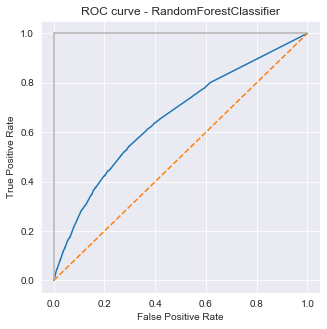

ROC AUC: 0.722


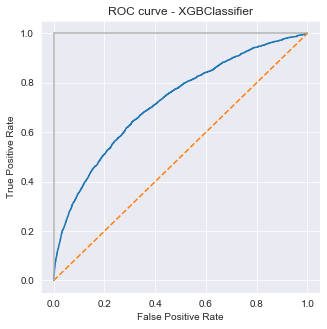

ROC AUC: 0.684


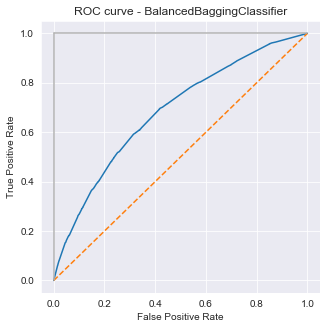

f1 Score= 0.301 AUC= 0.313


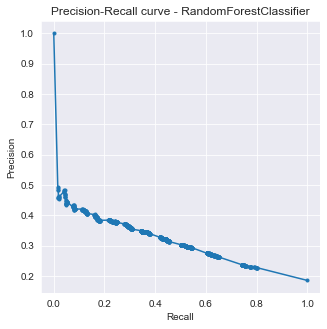

f1 Score= 0.224 AUC= 0.414


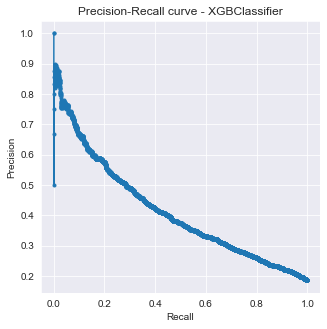

f1 Score= 0.392 AUC= 0.340


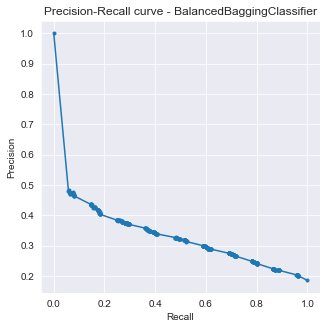

In [27]:
roc_auc(y_test, rf_probability, rf_model)
roc_auc(y_test, xgb_probability, xgb_model)
roc_auc(y_test, bbc_probability, bbc_model)

prec_rec(y_test, rf_pred, rf_probability, rf_model)
prec_rec(y_test, xgb_pred, xgb_probability, xgb_model)
prec_rec(y_test, bbc_pred, bbc_probability, bbc_model)

### 5. Comentarios Finales

Comparando los modelos de árboles de Random Forest y XGBoost, vemos que ambos tienen un buen performance, sobre 50% de
accuracy, 78% y 82% respectivamente. Los modelos les asignan distintas importancias a las variables, donde el
Random Forest considera más importantes las variables día, mes y periodo del día, mientras que el XGBoost da mayor
importancia a variables de las aerolíneas y los destinos, lo que es coincidente con lo encontrado en el análisis
exploratorio de datos de las variables que podrían influir en la probabilidad de atraso de los vuelos que aterrizan y
despegan del aeropuerto.

Para la predicción de si el vuelo se atrasa o no se analiza la matriz de confusión, el modelo de XGBoost predice que
salen más vuelos a tiempo que realmente salieron atrasados de lo que predice el Random Forest (2177 XGBoost vs 1889 RF),
pero se equivoca menos en la predicción de los que salen atrasados que realmente salieron a tiempo (216 XGBoost vs 1050
RF), es por eso que los valores de precision y recall aumentan y disminuyen respectivamente para la categoría atrasado
(clase 1) comparando RF vs XGBoost. Si vemos por otro lado la matriz de confusión del modelo de Ensamble balanceado se
predice una mayor cantidad de vuelos atrasados que realmente si estuvieron atrasados, lo que es una buena señal dado que
se busca mejorar los atrasos en la operación de los vuelos en el aeropuerto de Santiago.

Por otro lado, lo que realmente se busca en este desafio es predecir la **probabilidad** de atraso de un vuelo, es decir,
debemos utilizar las métricas que ayuden a mirar las probabilidades de atraso (`model.predict_proba`), por lo tanto
debemos mirar el AUC.

Random Forest -> AUC: 0.658

XGBoost -> AUC: 0.722

Ensamble con balanceo -> AUC: 0.684

Para reducir las probabilidades de atraso de los vuelos que despegan o aterrizan en el Aeropuerto de Santiago es
importante entender las variables que más afectan en estos atrasos, por eso es importante conocer la importancia de estas,
con este conocimiento se pueden tomar acciones de negocio para reducir la cantidad de atrasos y si mejoramos la métrica
podemos dar mayor interpretabilidad a esta importancia y tener mayor confiabilidad en la acción que se decida tomar. El
haber balanceado el dataset permite generalizar las conclusiones para las otras aerolíneas, dado que LATAM concentra la
mayor cantidad de vuelos en los datos. Buscamos que el AUC sea lo más cercano a 1 posible, dado que permite clasificar
con mayor probabilidad el atraso de un vuelo, por ende el modelo está prediciendo mejor.

Para mejorar la performance de los modelos se puede realizar tuneo de hiperparámetros, existen herramientas de python
que permiten encontrar el mejor set de parámetros para entrenar el modelo y maximizar el accuracy. Por otro lado se
pueden agregar variables explicativas externas, por ejemplo, cantidad de vuelos que salen en simultáneo o cercanos en
horario a distintos destinos, cantidad de pasajeros del vuelo, tiempo de boarding de los pasajeros en la puerta, tiempo
de carga de equipaje, entre otras condiciones externas.

Se decidió trabajar con Random Forest y XGBoost dado que después de probar con el modelo de probit, que no convergió,
los modelos de árboles son buenos predictores de problemas de analítica. No es necesario entrenar modelos tan complejos,
como por ejemplo redes neuronales para encontrar una solución que se ajuste a un problema, son costo eficientes y tiempo
eficientes, los modelos de árboles son rápidos de entrenar y escalables. Finalmente se decidió probar un modelo de
ensamble con balanceo para trabajar con las clases que se encontraban desbalanceadas en el dataset original, y con esto
obtener una mayor confianza en el valor del accuracy obtenido. El modelo que mejor métrica presenta es el de XGBoost, pero como mencionamos anteriormente considera las clases
desbalanceadas, por lo que el modelo de ensamble con balanceo se mantiene como la opción que elegiría para entrenar este
modelo de predicción de probabilidad de atraso de los vuelos.